Needed Imports

In [ ]:
from zipfile import ZipFile
import glob 
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from torchvision.utils import make_grid
from imgaug import augmenters as iaa 
import cv2 as cv
import imageio
import shutil

In [ ]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import seaborn as sns
import torchvision.models as models
import imgaug.augmenters as iaa
from tqdm import tqdm

from google.colab import drive

Using Free gpu of Google, with Cuda Library

In [ ]:
if torch.cuda.is_available():
  device=torch.device('cuda:0')
  print('Cuda')
else:
  device=torch.device('cpu')
  print('cpu')


Cuda


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with ZipFile('drive/MyDrive/archive.zip', 'r') as Zip:
   # Extract all the contents of zip file in different directory
   Zip.extractall('Images')

Getting all the directories in one directory called Images.

In [ ]:
def Get_all_folders_in_one_directory():
    for folders in glob.glob('Images/IDC_regular_ps50_idx5/*'):
        os.rename(folders, f"{folders}1")
        src="/".join(folders.split('/',2)[0:2])

        aim_fol=f"{(folders+str(1)).split('/',2)[2]}"
        folder=os.path.join(src,aim_fol)
        shutil.move(folder,f"Images/")
    shutil.rmtree(src)

Get_all_folders_in_one_directory()


Plot Some Images from dataset

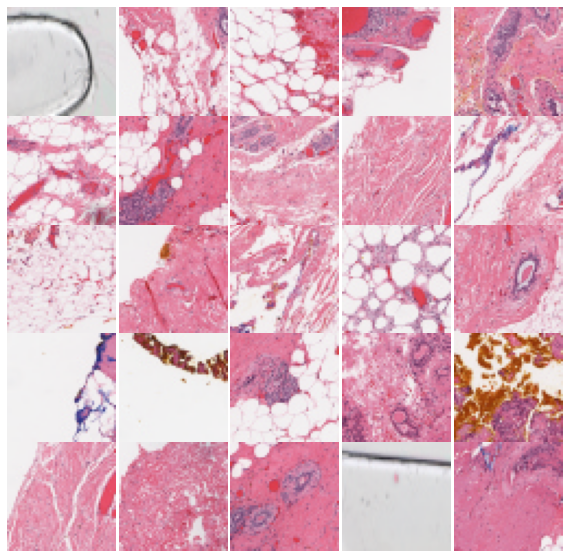

In [ ]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
i_=0
for l in glob.glob('Images/*/*/*'):
    im = cv.imread(l)
    im = cv.resize(im, (50, 50)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1
    if i_==25:
        break

Creating Dataframe of Dataset. Since names of the images contains it's class it makes easier to add names and classes to dataframe

In [ ]:
def Create_df():
    Images=[]
    Classes=[]
    for img in glob.glob('Images/*/*/*'):
      #gets full name
        Images.append(img[7:])
        #gets class
        Classes.append(int(img.split('.')[0][-1]))
    df_values=list(zip(Images,Classes))
    #creates dataframe and inserts zipped values of images and classes 
    df=pd.DataFrame(df_values,columns=['Image','Class'])
    #shuffles dataframe
    df=df.iloc[np.random.permutation(len(df))]
    df=df.reset_index(drop=True)
    return df

df=Create_df()
df

,Image,Class
0,91781/0/9178_idx5_x2151_y1751_class0.png,0
1,103081/1/10308_idx5_x1101_y1551_class1.png,1
2,8918/0/8918_idx5_x501_y2151_class0.png,0
3,12822/0/12822_idx5_x3401_y901_class0.png,0
4,102991/0/10299_idx5_x2101_y2251_class0.png,0
...,...,...
555043,10307/0/10307_idx5_x1601_y401_class0.png,0
555044,12881/1/12881_idx5_x501_y1451_class1.png,1
555045,14154/1/14154_idx5_x1751_y1351_class1.png,1
555046,12891/1/12891_idx5_x1401_y1251_class1.png,1


Class 0 is benign and class 1 is malignant

As we see, Data is quaite inbalanced. so we need to augment the images 
of the '1' class. 

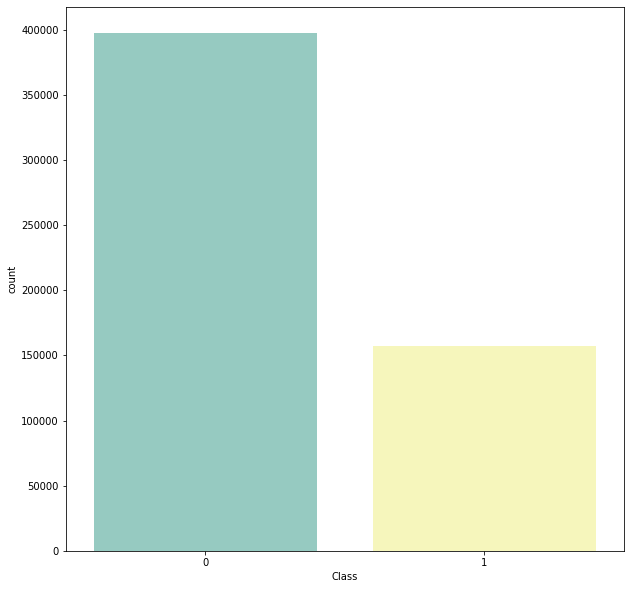

In [ ]:
sns.countplot(x='Class',data=df,palette='Set3')

Augmenting images with IMGAUG library. Chose these augmentation types. 
these augmentations are most relevant for medical tasks.

In [ ]:
aug = iaa.OneOf([
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.Affine(TranslateY(p=((-0.1, 0.1)))),
    iaa.Affine(rotate=45),
    iaa.Add(50, per_channel=True),
    iaa.Affine(scale=(0.5, 1.5)),
    iaa.shearY((-20, 20)),
    iaa.Rotate((-45, 45)),
    iaa.Affine(rotate=((-45,45))),
    iaa.LogContrast(gain=(0.6, 1.4))
    
])
path='Images/*/*/*'

Augmentation

In [ ]:
def Augmentation(augmentor,aug_path):
    img_names=[]
    img_classes=[]
    for image in glob.glob(aug_path):
      #gets all the images which are '1' class
        if int(image.split('.')[0][-1])==1:
            for i in range(3):
              #adding augmentation name as suffix
                aug_name=f"aug{image.split('/',4)[3]}"
                folder="/".join(image.split('/',3)[1:3])
                img=imageio.imread(image)
                aug=augmentor(image=img)
                #writing new image with new name in same folder
                cv.imwrite(f'Images/{folder}/{i}{aug_name}',aug)
                #appends image name 
                img_names.append(f'{folder}/{i}{aug_name}')
                #and 1 in img_classes because we are augmenting only images that have 1 class
                img_classes.append(1)
                #we will have 238000 new images to make data even
        if len(img_classes)>238000:
            break
    ziplists = list(zip(img_names, img_classes))
    #creating new dataframe to pass new images and classes
    new_df=pd.DataFrame(ziplists
                        ,columns=['Image','Class'])
    return new_df

aug_df=Augmentation(aug,path)           
    

Concatenating 3 dataframes with old and new images

In [ ]:
sec_df=pd.concat([df,aug_df],ignore_index=True)
sec_df

,Image,Class
0,91781/0/9178_idx5_x2151_y1751_class0.png,0
1,103081/1/10308_idx5_x1101_y1551_class1.png,1
2,8918/0/8918_idx5_x501_y2151_class0.png,0
3,12822/0/12822_idx5_x3401_y901_class0.png,0
4,102991/0/10299_idx5_x2101_y2251_class0.png,0
...,...,...
793045,129111/1/1aug12911_idx5_x1851_y1401_class1.png,1
793046,129111/1/2aug12911_idx5_x1851_y1401_class1.png,1
793047,129111/1/0aug12911_idx5_x2101_y1151_class1.png,1
793048,129111/1/1aug12911_idx5_x2101_y1151_class1.png,1


AS we see data is well balanced

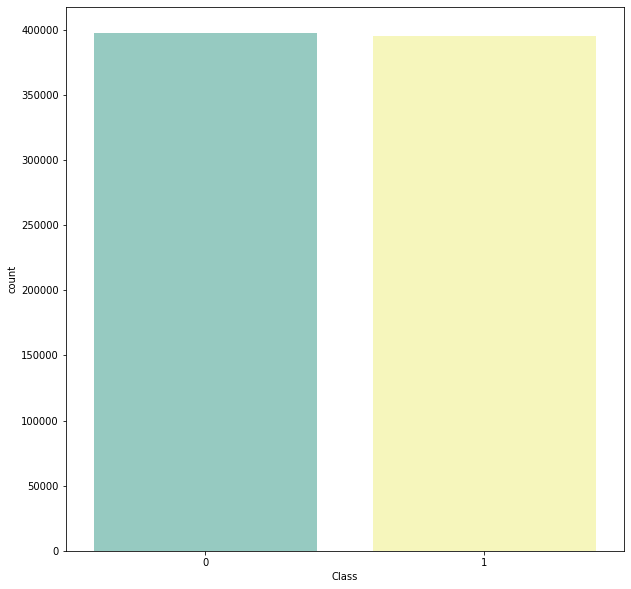

In [ ]:
sns.countplot(x='Class',data=sec_df,palette='Set3')

Deleting and dropping rows of the images that are ruined. The images which will not open as tensors. and also getting final Dataframe.

In [ ]:
def Delete_images(path,df):
    for image in df['Image']:
        img_path=os.path.join(path,image)
        try:
            img=cv.imread(img_path)
            x=img.shape
        except:
            os.remove(img_path)
            df = df[df['Image'] != Image]
#     df = df.sample(frac=1).reset_index(drop=True)
    df=df.iloc[np.random.permutation(len(df))]
    df=df.reset_index(drop=True)
    return df
        
dff=Delete_images('Images',sec_df)

data_path='Images'


        

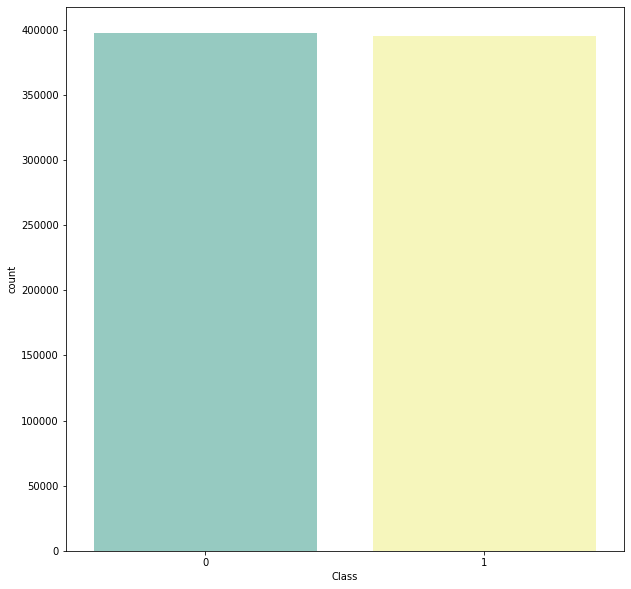

In [ ]:
sns.countplot(x='Class',data=dff,palette='Set3')

Custom Dataset.

In [ ]:
class BreastDataset(Dataset):
    def __init__(self,df,path):
        self.df=df
        self.path=path

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        img_path=os.path.join(self.path,self.df.iloc[index][0])
        img=cv.imread(img_path)
        img=cv.cvtColor(img, cv.COLOR_RGB2BGR)
        img=cv.resize(img,(50,50))
        img=torch.tensor(img)
        y_label=torch.tensor(self.df.iloc[index][1])
            
        return (img.float(),y_label)
        

dataset=BreastDataset(dff,data_path)
    

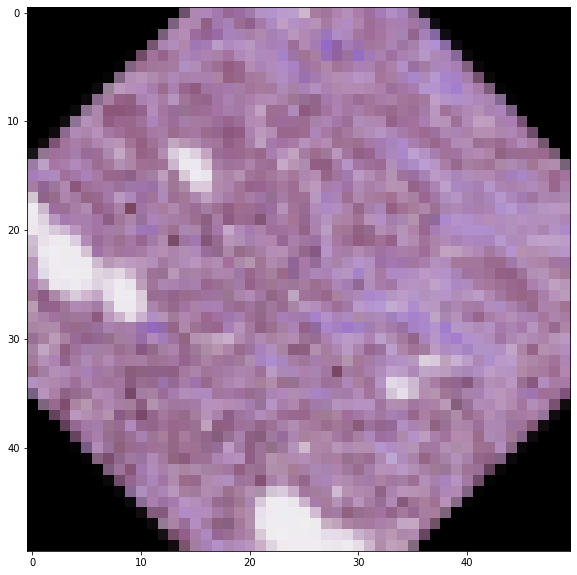

In [ ]:
plt.imshow(dataset.__getitem__(123)[0]/255)


In [ ]:
#Split Dataset Into Train,validation And Test Sets
train_set,val_set,test_set=torch.utils.data.random_split(dataset,[int(len(dataset)*0.7),round(len(dataset)*0.15),round(len(dataset)*0.15)-1])
train_loader=DataLoader(train_set,batch_size=128,shuffle=True)
val_loader=DataLoader(val_set,batch_size=64,shuffle=False)


Training Images with Resnet 18. 
just changing out features of last layer to be 2 because we have 2 classes.

In [ ]:
def load_model():
    model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)

    for param in model.parameters():
        param.requires_grad=True
        
    in_ftrs=model.fc.in_features
    model.fc=nn.Linear(in_ftrs,2)
    return model
    
# resnet18 = models.resnet18(pretrained=True)


In [ ]:
model=load_model().to(device)
model

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

I chose CrossEntropy as loss function. you can change that as binaryCrossEntropy.

In [ ]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
def train(model,optim,loss_f,num_of_epochs,path):
  #creating directory to save model.pt files
  try: 
    os.mkdir(path) 
  except:
    path=path

  test_losses=[]
  train_losses=[]
  train_correct=[]
  test_correct=[]
  #min loss and min acc for callback
  min_loss=1e+10
  min_acc=30
  for epoch in tqdm(range(num_of_epochs)):
    trn_corr=0
    tst_corr=0

    for b,(X_train,y_train) in enumerate(train_loader):
      b+=1
      X_train,y_train=X_train.to(device),y_train.to(device)

      y_pred=model(X_train.view(-1,3,50,50))
      #softmax returns the probabilities.
      y_pred=F.log_softmax(y_pred,dim=1)
      loss=loss_f(y_pred,y_train)

      predicted = torch.max(y_pred.data, 1)[1]
      batch_corr = (predicted == y_train).sum()
      trn_corr += batch_corr


      optim.zero_grad()
      loss.backward()
      optim.step()
    #Training Accuracy
    tr_acc=trn_corr.item()*100/(128*b)
    #train losses and train correct are for future visualization
    train_losses.append(loss)
    train_correct.append(trn_corr)
  #validation
    with torch.no_grad():
      for b,(X_test,y_test) in enumerate(val_loader):
        X_test,y_test=X_test.to(device),y_test.to(device)
        y_val=model(X_test.view(-1,3,50,50))
        predicted=torch.max(y_val.data,1)[1]
        tst_corr+=(predicted==y_test).sum()
      val_loss=loss_f(y_val,y_test)
      test_losses.append(loss)
      test_correct.append(tst_corr)
    vl_acc=tst_corr.item()*100/(64*b)
    #A callback. that saves best models for future use.
    if loss<min_loss or min_acc<tr_acc:
      min_loss=loss
      min_acc=tr_acc
      torch.save(model.state_dict(),f"{path}/model-loss : {loss}-acc {tr_acc}.pt")
    
    print(f'epoch: {epoch:2} train_loss: {loss.item():10.4f}  \
    train_accuracy: {tr_acc:7.3f}% val_loss : {val_loss} val_acc :{vl_acc:7.3f}% ')
    


In [ ]:
train(model,optimizer,criterion,10,'models')





  0%|          | 0/10 [00:00<?, ?it/s]



 10%|█         | 1/10 [13:18<1:59:46, 798.46s/it]

epoch:  0 train_loss:     0.2807      train_accuracy:  89.142% val_loss : 0.3056527376174927 val_acc : 89.972% 






 20%|██        | 2/10 [27:02<1:47:29, 806.17s/it]

epoch:  1 train_loss:     0.1658      train_accuracy:  90.347% val_loss : 0.29324501752853394 val_acc : 90.173% 






 30%|███       | 3/10 [40:51<1:34:50, 812.95s/it]

epoch:  2 train_loss:     0.2364      train_accuracy:  90.770% val_loss : 0.30062276124954224 val_acc : 90.532% 






 40%|████      | 4/10 [54:44<1:21:53, 818.96s/it]

epoch:  3 train_loss:     0.2377      train_accuracy:  91.159% val_loss : 0.25936388969421387 val_acc : 90.776% 






 50%|█████     | 5/10 [1:08:38<1:08:38, 823.60s/it]

epoch:  4 train_loss:     0.1755      train_accuracy:  91.802% val_loss : 0.24920007586479187 val_acc : 91.310% 






 60%|██████    | 6/10 [1:22:22<54:54, 823.65s/it]  

epoch:  5 train_loss:     0.2723      train_accuracy:  92.980% val_loss : 0.29950326681137085 val_acc : 91.844% 






 70%|███████   | 7/10 [1:36:04<41:09, 823.04s/it]

epoch:  6 train_loss:     0.1069      train_accuracy:  94.557% val_loss : 0.21944542229175568 val_acc : 92.504% 






 80%|████████  | 8/10 [1:49:52<27:29, 824.66s/it]

epoch:  7 train_loss:     0.0888      train_accuracy:  96.017% val_loss : 0.23548856377601624 val_acc : 93.494% 






 90%|█████████ | 9/10 [2:03:30<13:42, 822.62s/it]

epoch:  8 train_loss:     0.0728      train_accuracy:  96.992% val_loss : 0.15646281838417053 val_acc : 94.127% 






100%|██████████| 10/10 [2:17:17<00:00, 823.73s/it]

epoch:  9 train_loss:     0.0787      train_accuracy:  97.654% val_loss : 0.12075028568506241 val_acc : 94.581% 


In [ ]:
#these are saved models. We've got 97% percent acc, thats pretty high. you just load model with torch.load() and test it on test_set.

models/model-loss : 0.1754828244447708-acc 91.80200887710399.pt
models/model-loss : 0.08878165483474731-acc 96.0166517754208.pt
models/model-loss : 0.10688366740942001-acc 94.55700945353931.pt
models/model-loss : 0.07868348062038422-acc 97.65408836753517.pt
models/model-loss : 0.28066855669021606-acc 89.14175985704404.pt
models/model-loss : 0.07275363802909851-acc 96.99154801706248.pt
models/model-loss : 0.1658250391483307-acc 90.34668982015218.pt
models/model-loss : 0.23637042939662933-acc 90.77018964722159.pt
models/model-loss : 0.2376672923564911-acc 91.15946362693106.pt
models/model-loss : 0.2722640931606293-acc 92.98045884251788.pt
